# Import packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout

%matplotlib inline

Sets all random seeds for the program

In [2]:
tf.keras.utils.set_random_seed(12345)

# Load dataset

[mnist](http://yann.lecun.com/exdb/mnist/)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_test = x_test.reshape(-1, 28, 28, 1)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f"shape of train image: {x_train.shape}")
print(f"shape of train label: {y_train.shape}")
print(f"shape of test image: {x_test.shape}")
print(f"shape of train label: {y_test.shape}")

11490434/11490434 [==============================] - 2s 0us/step
shape of train image: (60000, 28, 28, 1)
shape of train label: (60000, 10)
shape of test image: (10000, 28, 28, 1)
shape of train label: (10000, 10)


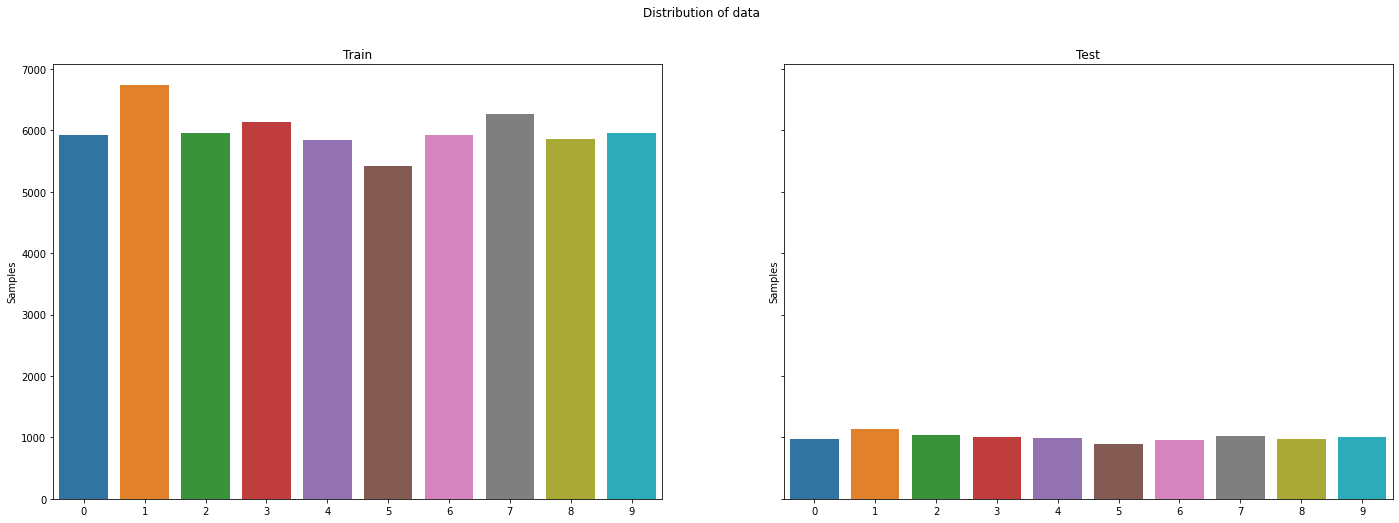

In [4]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(24, 8))
fig.suptitle('Distribution of data')

sns.countplot(ax=ax[0], x=np.argmax(y_train, axis=1)) 
ax[0].set_title('Train')
ax[0].set_ylabel('Samples')

sns.countplot(ax=ax[1], x=np.argmax(y_test, axis=1)) 
ax[1].set_title('Test')
ax[1].set_ylabel('Samples')

plt.show()

## Display image

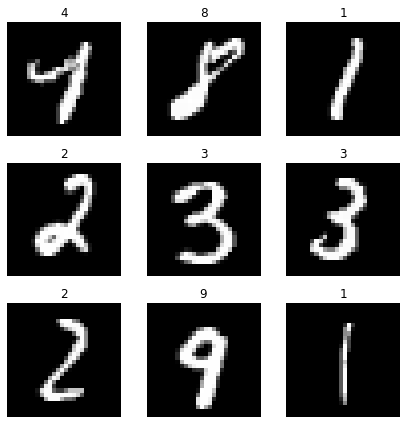

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))

for c, i in enumerate(np.random.randint(x_train.shape[0], size=9)):
  ax[c//3][c%3].set_title(np.argmax(y_train[i]))
  ax[c//3][c%3].axis('off')
  ax[c//3][c%3].imshow(x_train[i].squeeze(2), cmap='gray')

plt.tight_layout()
plt.show()

## Rescaling

In [6]:
rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255)
])

In [7]:
print(f"before rescaling min: {x_train[1].min()}, max: {x_train[1].max()}")
print(f"after rescaling min: {rescale(x_train[1]).numpy().min()}, max: {rescale(x_train[1]).numpy().max()}")

before rescaling min: 0, max: 255
after rescaling min: 0.0, max: 1.0


## Data augmentation

透過旋轉和縮放進行Data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  # Add your transforms here
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(.5, .2),
])

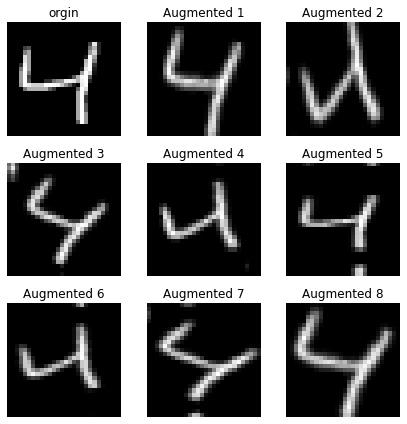

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))

for i in range(9):
  if i == 0:
    image = x_train[2].squeeze(2)
    ax[i//3][i%3].set_title('orgin')
  else:
    image = data_augmentation(rescale(x_train[2])).numpy().squeeze(2)
    ax[i//3][i%3].set_title(f'Augmented {i}')

  ax[i//3][i%3].axis('off')
  ax[i//3][i%3].imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# CNN model

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
)

## Keras model

### Sequential model
[Document](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

In [12]:
model1 = tf.keras.Sequential([
    # Add convolution, pooling, flatten here 
    tf.keras.Input(shape=(28, 28, 1), name='input_layer'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(.5, .2),
    tf.keras.layers.Conv2D(16, 5, activation='relu', padding="same", name="conv_layer_1", input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name="pooling_layer_1"),
    tf.keras.layers.Conv2D(16, 5, activation='relu', padding="same", name="conv_layer_2", input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name="pooling_layer_2"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu", name="hidden_layer_1"),
    tf.keras.layers.Dense(64, activation="relu", name="hidden_layer_2"),
    tf.keras.layers.Dense(10, name="output_layer"),
  ], name="sequential_model")

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MSE, metrics=['accuracy'])
model1.summary()

Model: "sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 16)        416       
                                                                 
 pooling_layer_1 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv_layer_2 (Conv2D)       (None, 13, 13, 16)        6416      
                                                                 
 pooling_layer_2 (MaxPooling  (None, 6, 6, 16)    

### Functional API
[Document](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [13]:
# Add convolution, pooling, flatten here
inputs = tf.keras.Input(shape=(28, 28, 1), name='input_layer')
x = tf.keras.layers.RandomRotation(0.1)(inputs)
x = tf.keras.layers.RandomZoom(.5, .2)(x)
x = tf.keras.layers.Conv2D(16, 5, activation='relu', padding="same", name="conv_layer_1", input_shape=(28, 28, 1))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name="pooling_layer_1")(x)
x = tf.keras.layers.Conv2D(16, 5, activation='relu', padding="same", name="conv_layer_2", input_shape=(28, 28, 1))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name="pooling_layer_2")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu", name='hidden_layer_1')(x)
x = tf.keras.layers.Dense(64, activation="relu", name='hidden_layer_2')(x)
outputs = tf.keras.layers.Dense(10, name='output_layer')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="functional_api")
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MSE, metrics=['accuracy'])
model2.summary()

Model: "functional_api"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 28, 28, 16)        416       
                                                                 
 pooling_layer_1 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv_layer_2 (Conv2D)       (None, 13, 13, 16)     

In [14]:
history = model1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping], # put your callbacks in a list
)

Epoch 1/100
469/469 [==============================] - 11s 7ms/step - loss: 1.4196 - accuracy: 0.1054 - val_loss: 0.0963 - val_accuracy: 0.1019
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0929 - accuracy: 0.1027 - val_loss: 0.0914 - val_accuracy: 0.1012
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0905 - accuracy: 0.1025 - val_loss: 0.0903 - val_accuracy: 0.1088
Epoch 4/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0900 - accuracy: 0.1084 - val_loss: 0.0901 - val_accuracy: 0.1088
Epoch 5/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0900 - accuracy: 0.1073 - val_loss: 0.0901 - val_accuracy: 0.1086
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0900 - accuracy: 0.1083 - val_loss: 0.0900 - val_accuracy: 0.1102
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0900 - accuracy: 0.1068 - val_loss: 0.0900 - val_accuracy: 0.111

In [15]:
result = model1.evaluate(x_test, y_test, batch_size=64)
print('test data loss:', result[0])
print('test data accuracy:', result[1])

157/157 [==============================] - 1s 4ms/step - loss: 0.0138 - accuracy: 0.8876
test data loss: 0.0138393584638834
test data accuracy: 0.8876000046730042


In [16]:
history = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping], # put your callbacks in a list
)

Epoch 1/100
469/469 [==============================] - 4s 6ms/step - loss: 2.5327 - accuracy: 0.1636 - val_loss: 0.0871 - val_accuracy: 0.2464
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0824 - accuracy: 0.2484 - val_loss: 0.0825 - val_accuracy: 0.2658
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0791 - accuracy: 0.2733 - val_loss: 0.0795 - val_accuracy: 0.2848
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0769 - accuracy: 0.3011 - val_loss: 0.0770 - val_accuracy: 0.3075
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0752 - accuracy: 0.3202 - val_loss: 0.0765 - val_accuracy: 0.3333
Epoch 6/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0729 - accuracy: 0.3686 - val_loss: 0.0746 - val_accuracy: 0.4308
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0640 - accuracy: 0.5058 - val_loss: 0.0603 - val_accuracy: 0.5444

In [17]:
result = model2.evaluate(x_test, y_test, batch_size=64)
print('test data loss:', result[0])
print('test data accuracy:', result[1])

157/157 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 0.9858
test data loss: 0.005119128152728081
test data accuracy: 0.98580002784729
